In [1]:
from sklearn.datasets import load_files      
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input

Using TensorFlow backend.


### Display nodes

In [2]:
from __future__ import print_function
def display_nodes(nodes):
    for i, node in enumerate(nodes):
        print('%d %s %s' % (i, node.name, node.op))
        [print(u'└─── %d ─ %s' % (i, n)) for i, n in enumerate(node.input)]

### Work around GPU memory issues (not needed with GTX1080)

In [3]:
NEED_GPU_MEM_WORKAROUND = False
if (NEED_GPU_MEM_WORKAROUND):
    print('Working around TF GPU mem issues')
    import tensorflow as tf
    import keras.backend.tensorflow_backend as ktf

    def get_session(gpu_fraction=0.6):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=True)
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

    ktf.set_session(get_session())

In [4]:
img_width, img_height = 224, 224 # change based on the shape/structure of your images
num_classes = 2 # Fire or Safe

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    fire_files = np.array(data['filenames'])
    fire_targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    return fire_files, fire_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('fireImages/train')
valid_files, valid_targets = load_dataset('fireImages/valid')
test_files, test_targets = load_dataset('fireImages/test')

# load list of fire classes
class_names = [item[21:-1] for item in sorted(glob("fireImages/train/*/"))]

# print statistics about the dataset
print('There are %d total fire categories.' % len(class_names))
print('There are %s total fire images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training fire images.' % len(train_files))
print('There are %d validation fire images.' % len(valid_files))
print('There are %d test fire images.'% len(test_files))

There are 2 total fire categories.
There are 1069 total fire images.

There are 1015 training fire images.
There are 45 validation fire images.
There are 9 test fire images.


In [5]:
class_names

['Fire', 'Safe']

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
from PIL import ImageFile       
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = preprocess_input( paths_to_tensor(train_files) )
valid_tensors = preprocess_input( paths_to_tensor(valid_files) )
test_tensors  = preprocess_input( paths_to_tensor(test_files) )

100%|██████████| 9/9 [00:00<00:00, 26.03it/s]


### Detect fire with the most accurate model

In [8]:
### Define the architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import applications

from keras.applications.resnet50 import preprocess_input, decode_predictions
VGG16_model       = applications.VGG16(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)
InceptionV3_model = applications.InceptionV3(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)
Xception_model    = applications.Xception(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)
ResNet50_model    = applications.ResNet50(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)
VGG19_model       = applications.VGG19(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)

/home/ngeorgis/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### Pick the most accurate model for this application

In [9]:
#base_model = InceptionV3_model
#base_model = Xception_model
#base_model = ResNet50_model
base_model = VGG16_model
#base_model = VGG19_model

In [10]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Transfer learning (freeze base model layers)

In [11]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [12]:
# Freeze the layers which you don't want to train. 
for layer in base_model.layers:
    layer.trainable = False

# Here I am freezing the first 5 layers.
# for layer in model.layers[:5]:
#    layer.trainable = False

In [13]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.45)(x)
# and a logistic layer we have num_classes classes
predictions = Dense(num_classes, activation='softmax')(x)

In [14]:
from keras.models import Model
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Note that we only train 1,539 params and the rest are frozen:

* Total params: 20,025,410
* Trainable params: 1,026
* Non-trainable params: 20,024,384


In [17]:
from keras.callbacks import ModelCheckpoint   
from keras.callbacks import TensorBoard

tbCallback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

import keras.backend.tensorflow_backend as K

# train the model
checkpointer = ModelCheckpoint(filepath='firemodel.weights.best.hdf5', verbose=3, save_best_only=True)
hist = model.fit(train_tensors, train_targets, batch_size=64, epochs=10,
      validation_data=(valid_tensors, valid_targets), callbacks=[checkpointer, tbCallback],
      verbose=2)  #, shuffle=True)

Train on 1015 samples, validate on 45 samples
Epoch 1/10
 - 11s - loss: 0.6283 - acc: 0.8276 - val_loss: 0.3219 - val_acc: 0.8889

Epoch 00001: val_loss improved from inf to 0.32187, saving model to firemodel.weights.best.hdf5
Epoch 2/10
 - 4s - loss: 0.3628 - acc: 0.8926 - val_loss: 0.3590 - val_acc: 0.8889

Epoch 00002: val_loss did not improve from 0.32187
Epoch 3/10
 - 4s - loss: 0.2964 - acc: 0.8995 - val_loss: 0.2710 - val_acc: 0.8889

Epoch 00003: val_loss improved from 0.32187 to 0.27101, saving model to firemodel.weights.best.hdf5
Epoch 4/10
 - 4s - loss: 0.2285 - acc: 0.9222 - val_loss: 0.2086 - val_acc: 0.9111

Epoch 00004: val_loss improved from 0.27101 to 0.20855, saving model to firemodel.weights.best.hdf5
Epoch 5/10
 - 4s - loss: 0.1947 - acc: 0.9320 - val_loss: 0.2328 - val_acc: 0.9111

Epoch 00005: val_loss did not improve from 0.20855
Epoch 6/10
 - 4s - loss: 0.1661 - acc: 0.9438 - val_loss: 0.1794 - val_acc: 0.9333

Epoch 00006: val_loss improved from 0.20855 to 0.17

In [18]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_1


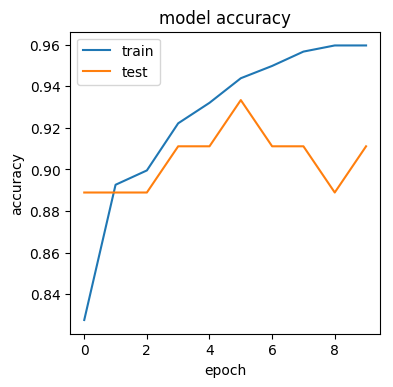

<Figure size 432x288 with 0 Axes>

In [19]:
import cv2                
import matplotlib.pyplot as plt                        

# summarize history for accuracy
plt.figure(figsize=(4,4), dpi=100 )
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('training1.png', dpi=300)

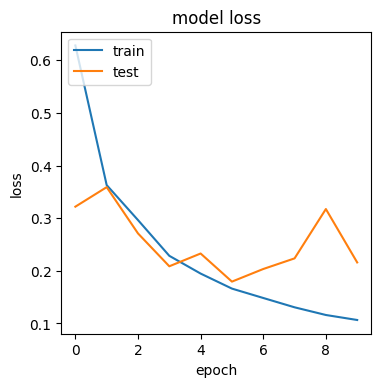

In [20]:
# summarize history for loss
plt.figure(figsize=(4,4), dpi=100 )
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Load the Model with the Best Validation Loss

In [21]:
### Load the model weights with the best validation loss.
model.load_weights('firemodel.weights.best.hdf5')

## Test the Fire detection Model
### Calculate classification accuracy on the test dataset.

In [22]:
# get index of predicted fire class for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

In [23]:
# report test accuracy
test_accuracy = 100*np.sum ( np.array( predictions)==np.argmax(test_targets, axis=1) ) / len(predictions )
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 100.0000%


In [24]:
# test validation accuracy
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in valid_tensors]
valid_accuracy = 100*np.sum ( np.array( predictions)==np.argmax(valid_targets, axis=1) ) / len(predictions )
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 93.3333%


In [25]:
def detect_fire(img_path):
    predicted_vector = model.predict(preprocess_input(path_to_tensor(img_path)))
    return class_names[np.argmax(predicted_vector)]

<Figure size 432x288 with 0 Axes>

_____________________________________________________________________________________________

Looking good: Safe


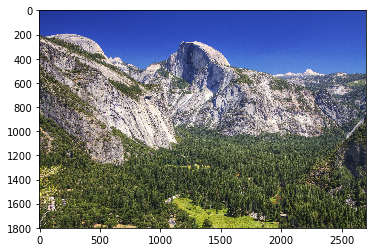

_____________________________________________________________________________________________

Looking good: Safe


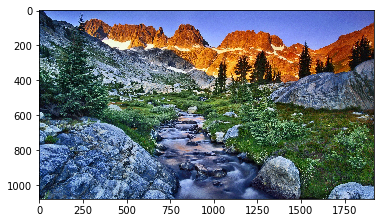

_____________________________________________________________________________________________

Looking good: Safe


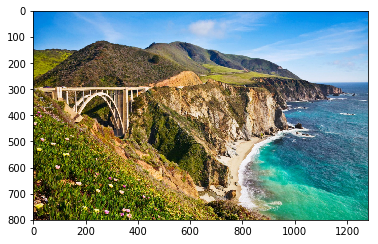

_____________________________________________________________________________________________

ALARM: Detected Fire


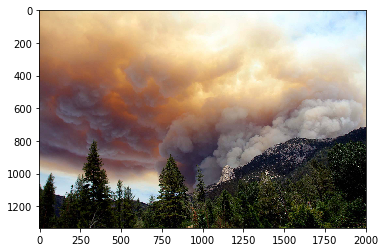

_____________________________________________________________________________________________

Looking good: Safe


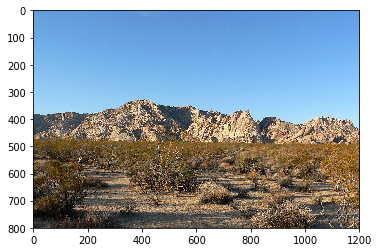

_____________________________________________________________________________________________

ALARM: Detected Fire


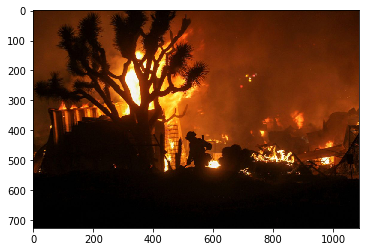

_____________________________________________________________________________________________

ALARM: Detected Fire


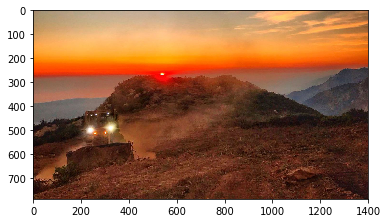

_____________________________________________________________________________________________

ALARM: Detected Fire


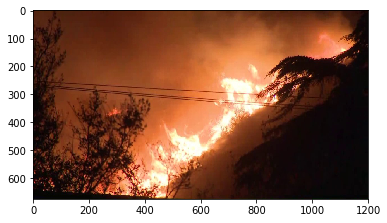

_____________________________________________________________________________________________

ALARM: Detected Fire


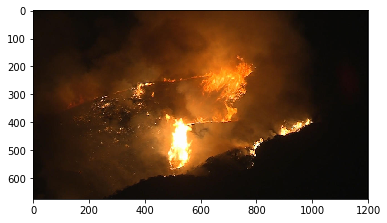

In [26]:
import glob
from PIL import Image 
from IPython import display

path = "test_images/*"
for fname in glob.glob(path):
    fire_detection = detect_fire( fname )
    display.display(plt.gcf())
    print('_____________________________________________________________________________________________')
    print('')
    if (fire_detection=='Fire'):
        print ('\033[1m'+'\033[91m'+'ALARM: Detected '+fire_detection.replace("_", ""))
    elif (fire_detection=='Smoke'):
        print ('\033[1m'+'\033[91m'+'ALARM: Detected '+fire_detection.replace("_", ""))
    else:
        print ('\033[1m'+'\033[92m'+'Looking good: ' +fire_detection.replace("_", ""))
    plt.imshow(Image.open(fname))
    #raw_input()


# Convert the Keras / TF model to something that Jetson TX2 understands

### Freeze the graph

In [27]:
from keras.models import load_model
from tensorflow.python.framework import graph_io
from tensorflow.python.tools import freeze_graph
from tensorflow.core.protobuf import saver_pb2
from tensorflow.python.training import saver as saver_lib

In [28]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [29]:
from keras import backend as K
import tensorflow as tf
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

INFO:tensorflow:Froze 1742 variables.
INFO:tensorflow:Converted 1742 variables to const ops.


In [30]:
tf.train.write_graph(frozen_graph, "./", "frozen_fire_detector.pb", as_text=False)

'./frozen_fire_detector.pb'

### Convert to UFF

In [31]:
!convert-to-uff --input-file frozen_fire_detector.pb -l

Loading frozen_fire_detector.pb
Instructions for updating:
Use tf.gfile.GFile.
UFF Version 0.5.5
=== Automatically deduced input nodes ===
[name: "input_1"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 224
      }
      dim {
        size: 224
      }
      dim {
        size: 3
      }
    }
  }
}
]

=== Automatically deduced output nodes ===
[name: "dense_1/Softmax"
op: "Softmax"
input: "dense_1/BiasAdd"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
]

1 Placeholder: "input_1"
2 Const: "block1_conv1/kernel"
3 Const: "block1_conv1/bias"
4 Conv2D: "block1_conv1/convolution"
5 BiasAdd: "block1_conv1/BiasAdd"
6 Relu: "block1_conv1/Relu"
7 Const: "block1_conv2/kernel"
8 Const: "block1_conv2/bias"
9 Conv2D: "block1_conv2/convolution"
10 BiasAdd: "block1_conv2/BiasAdd"
11 Relu: "block1_conv2/Relu"
12 MaxPool: "block1_pool/MaxPool"
13 Const: "block2_c

### Convert to uff 

In [32]:
!convert-to-uff -o fire_detector.uff --input-file frozen_fire_detector.pb

Loading frozen_fire_detector.pb
Instructions for updating:
Use tf.gfile.GFile.
UFF Version 0.5.5
=== Automatically deduced input nodes ===
[name: "input_1"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 224
      }
      dim {
        size: 224
      }
      dim {
        size: 3
      }
    }
  }
}
]

=== Automatically deduced output nodes ===
[name: "dense_1/Softmax"
op: "Softmax"
input: "dense_1/BiasAdd"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
]

Using output node dense_1/Softmax
Converting to UFF graph
No. nodes: 78
UFF Output written to fire_detector.uff


In [33]:
!ls -lh fire_detector.uff

-rw-rw-r-- 1 ngeorgis ngeorgis 57M Jan 27 20:53 fire_detector.uff


### Visualize model using tensorboard

![title](fire_nodes.png)